In [9]:
import pygor.load 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data_path = 'C:/Users/Michael Forsthofer/OneDrive - University of Sussex/BadenLab/2p-imaging/contralateral_OT_singleplane/st66/'


In [10]:
filename = '2024-8-14_x240814_2_4cOT.h5'
data_object = pygor.load.Core(data_path+filename)

C:\Users\Michael Forsthofer\Coding\pygor\src\pygor\classes\core_data.py:64: UserWarning: 'wDataCh0_detrended' not found in C:\Users\Michael Forsthofer\OneDrive - University of Sussex\BadenLab\2p-imaging\contralateral_OT_singleplane\st66\2024-8-14_x240814_2_4cOT.h5, setting to np.nan
  self.images = try_fetch(HDF5_file, "wDataCh0_detrended")
C:\Users\Michael Forsthofer\Coding\pygor\src\pygor\classes\core_data.py:75: UserWarning: 'Positions' not found in C:\Users\Michael Forsthofer\OneDrive - University of Sussex\BadenLab\2p-imaging\contralateral_OT_singleplane\st66\2024-8-14_x240814_2_4cOT.h5, setting to np.nan
  self.ipl_depths = try_fetch(HDF5_file, "Positions")
C:\Users\Michael Forsthofer\Coding\pygor\src\pygor\classes\core_data.py:77: UserWarning: 'Snippets0' not found in C:\Users\Michael Forsthofer\OneDrive - University of Sussex\BadenLab\2p-imaging\contralateral_OT_singleplane\st66\2024-8-14_x240814_2_4cOT.h5, setting to np.nan
  self.snippets = try_fetch(HDF5_file, "Snippets0")
C

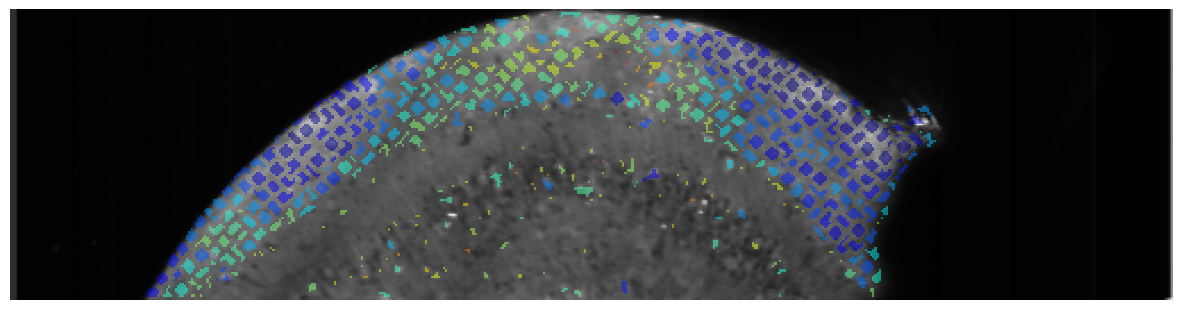

In [11]:
data_object.view_stack_rois(labels=False, figsize_scale=3, func='average_stack')

<b>Find where rois are located</b>

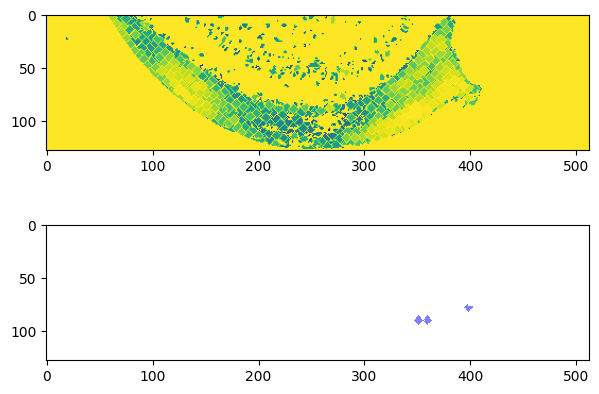

In [12]:
f, ax = plt.subplots(2, 1, figsize=(7, 5))
ax[0].imshow(data_object.rois)

from matplotlib.colors import ListedColormap
data = data_object.rois
values_to_plot = [-1, -5, -46]
mask = np.isin(data, values_to_plot)
cmap = ListedColormap([(0, 0, 1, 0), (0, 0, 1, 0.5)]) 
ax[1].imshow(mask, cmap=cmap, interpolation='none')


<b>Get mean traces</b>

<b>Get stimulus triggers</b>

In [13]:
print(data_object.ms_dur)
print(data_object.frame_hz)
print(len(data_object.triggerstimes_frame))
print(data_object.linedur_s)
print(data_object.trigger_mode)


30802
3.9941205978393555
32
0.001955999992787838
9


In [14]:
def flexible_reshape(array, columns):
    # Calculate the number of elements to keep
    elements_to_keep = (len(array) // columns) * columns
    # Reshape the array
    reshaped_array = array[:elements_to_keep].reshape(-1, columns)
    return reshaped_array

triggertimes_ms = (data_object.triggerstimes_frame-data_object.triggerstimes_frame[0])/data_object.frame_hz/data_object.linedur_s

mean_triggertimes_ms = flexible_reshape(triggertimes_ms, data_object.trigger_mode)
mean_triggertimes_ms = np.mean(mean_triggertimes_ms, axis=0)-np.mean(mean_triggertimes_ms, axis=0)[0]

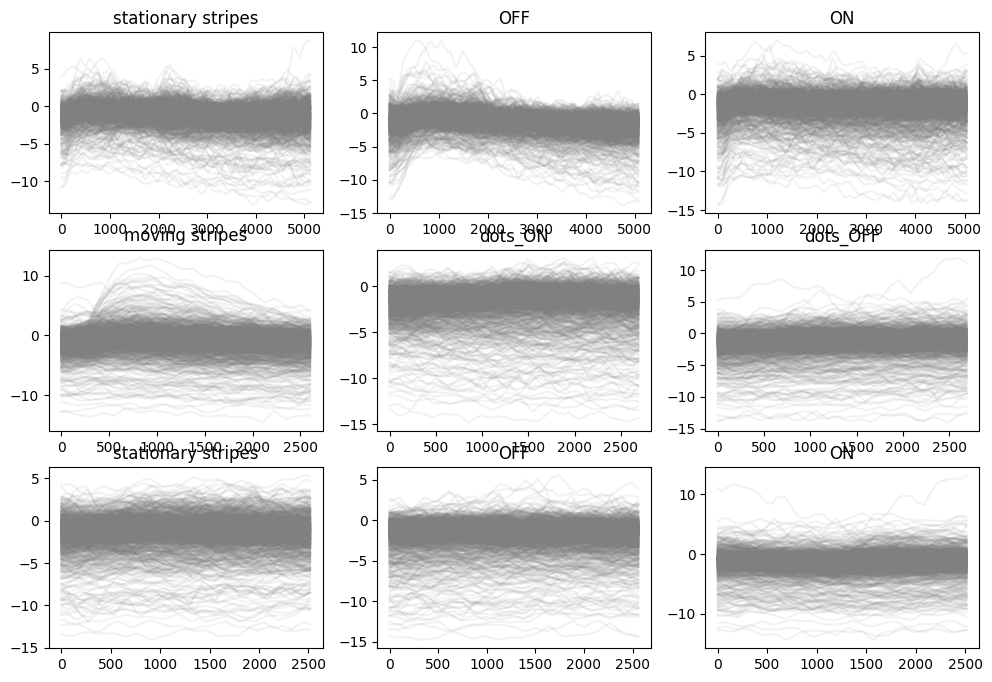

In [165]:
traces = data_object.averages
mean_triggertimes_extended = np.round(np.append(mean_triggertimes_ms, len(traces.transpose()))).astype(int)
stimtypes = ['stationary stripes','moving stripes','stationary stripes','OFF','dots_ON','OFF','ON','dots_OFF','ON',]
stim_responses = []

f, ax = plt.subplots(3, 3, figsize=(12, 8))

for idx, i in enumerate(mean_triggertimes_extended[:-1]):
    stim_responses.append(traces[:,i:mean_triggertimes_extended[idx+1]].transpose())  


for idx, i in enumerate(stim_responses):
    ax[idx%3, idx//3].plot(i, color='gray', alpha=0.1)  
    ax[idx%3, idx//3].set_xticklabels([])
    ax[idx%3, idx//3].set_title(stimtypes[idx])
    #ax[idx%3, idx//3].set_ylim(-5, 5)

In [61]:
from sklearn import cluster

stim_clusters = []

for idx, i in enumerate(stim_responses):

    dots_OFF = stim_responses[7]-stim_responses[7][1,:]
    dots_off = dots_OFF.transpose()

    kmeans_data = cluster.KMeans(n_clusters=3, init='k-means++', random_state=0)

    kmeans_data.fit(dots_off)

    labels = kmeans_data.labels_


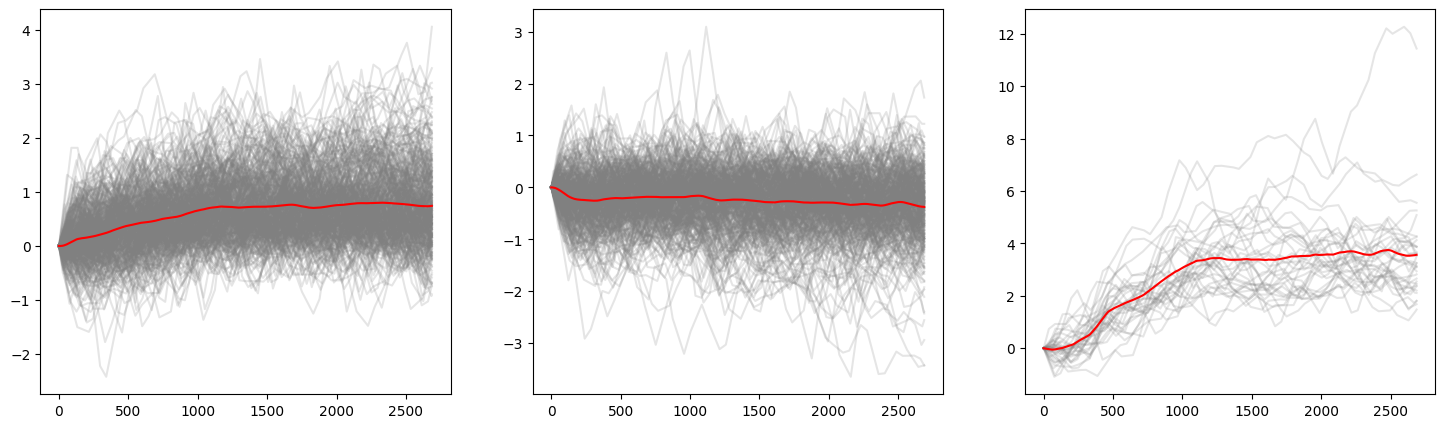

In [62]:
f, ax = plt.subplots(1, 3, figsize=(18, 5))
for idx, i in enumerate(np.unique(labels)):
    ax[idx].plot(dots_off[labels==i,:].transpose(), color='gray', alpha=0.2)
    ax[idx].plot(np.mean(dots_off[labels==i,:].transpose(), axis=1), color='r')

Plot rois by cluster allocation

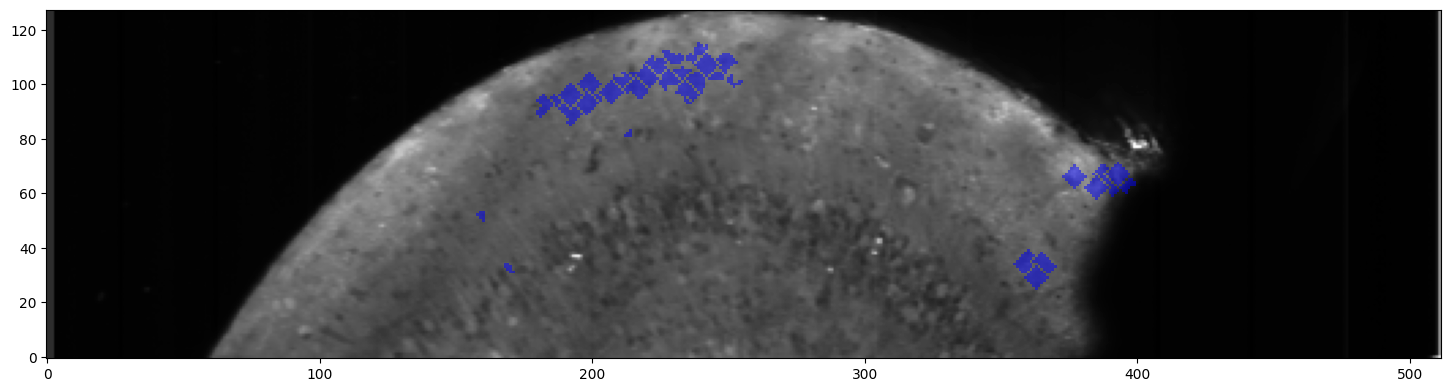

In [64]:
from matplotlib.colors import ListedColormap
f, ax = plt.subplots(1, 1, figsize=(18, 5))

rois = data_object.rois
found_rois = (np.where(labels==2)[0]+1)*-1
mask = np.isin(data, found_rois)
cmap = ListedColormap([(0, 0, 1, 0), (0, 0, 1, 0.5)]) 
ax.imshow(data_object.average_stack, cmap = "Greys_r", origin = "lower")
ax.imshow(mask, cmap=cmap, interpolation='none', origin="lower")




Calculate how many clusters are suitable for k-means

In [192]:
n_clusters_list = []


#find out hwo many clusters we need for each response section
for iter_responses in stim_responses:
    cost = []
    n_clust = 15
    for i in range(1, n_clust):
        kmeans_data = cluster.KMeans(n_clusters=i, init='k-means++', random_state=0)
        kmeans_data.fit(iter_responses.transpose())
        cost.append(kmeans_data.inertia_)

    n_clusters = len(np.where(abs(np.diff(np.diff(cost)))/abs(np.diff(np.diff(cost)))[-1]>5)[0])
    n_clusters_list.append(n_clusters)

In [193]:
n_clusters_list

[3, 5, 8, 9, 8, 5, 4, 8, 9]

In [194]:
cluster_labels = []
#get the clusters for each response
for idx, i in enumerate(n_clusters_list):
    kmeans_data = cluster.KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans_data.fit(stim_responses[idx].transpose())
    cluster_labels.append(kmeans_data.labels_)


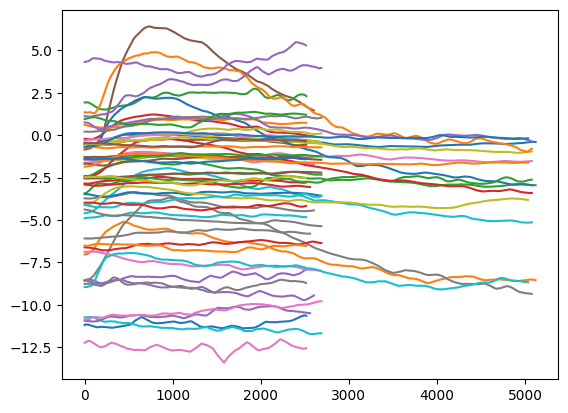

In [196]:
#for each response section, find the clusters that have a positive response to the stimulus
stim_responsive_clusters = []
for idx_stim, cur_label_array in enumerate(cluster_labels):
    for idx_label, cur_label in enumerate(np.unique(cur_label_array)):
        cur_cluster_mean = np.mean(stim_responses[idx_stim][:,cur_label_array==cur_label], axis=1)
        plt.plot(cur_cluster_mean)

In [184]:
np.shape(stim_responses[idx])



(2514, 798)

In [191]:
len(kmeans_data.labels_)

798

Try other clustering methods: self-organizing maps (SOM)

AttributeError: 'numpy.ndarray' object has no attribute 'tight_layout'

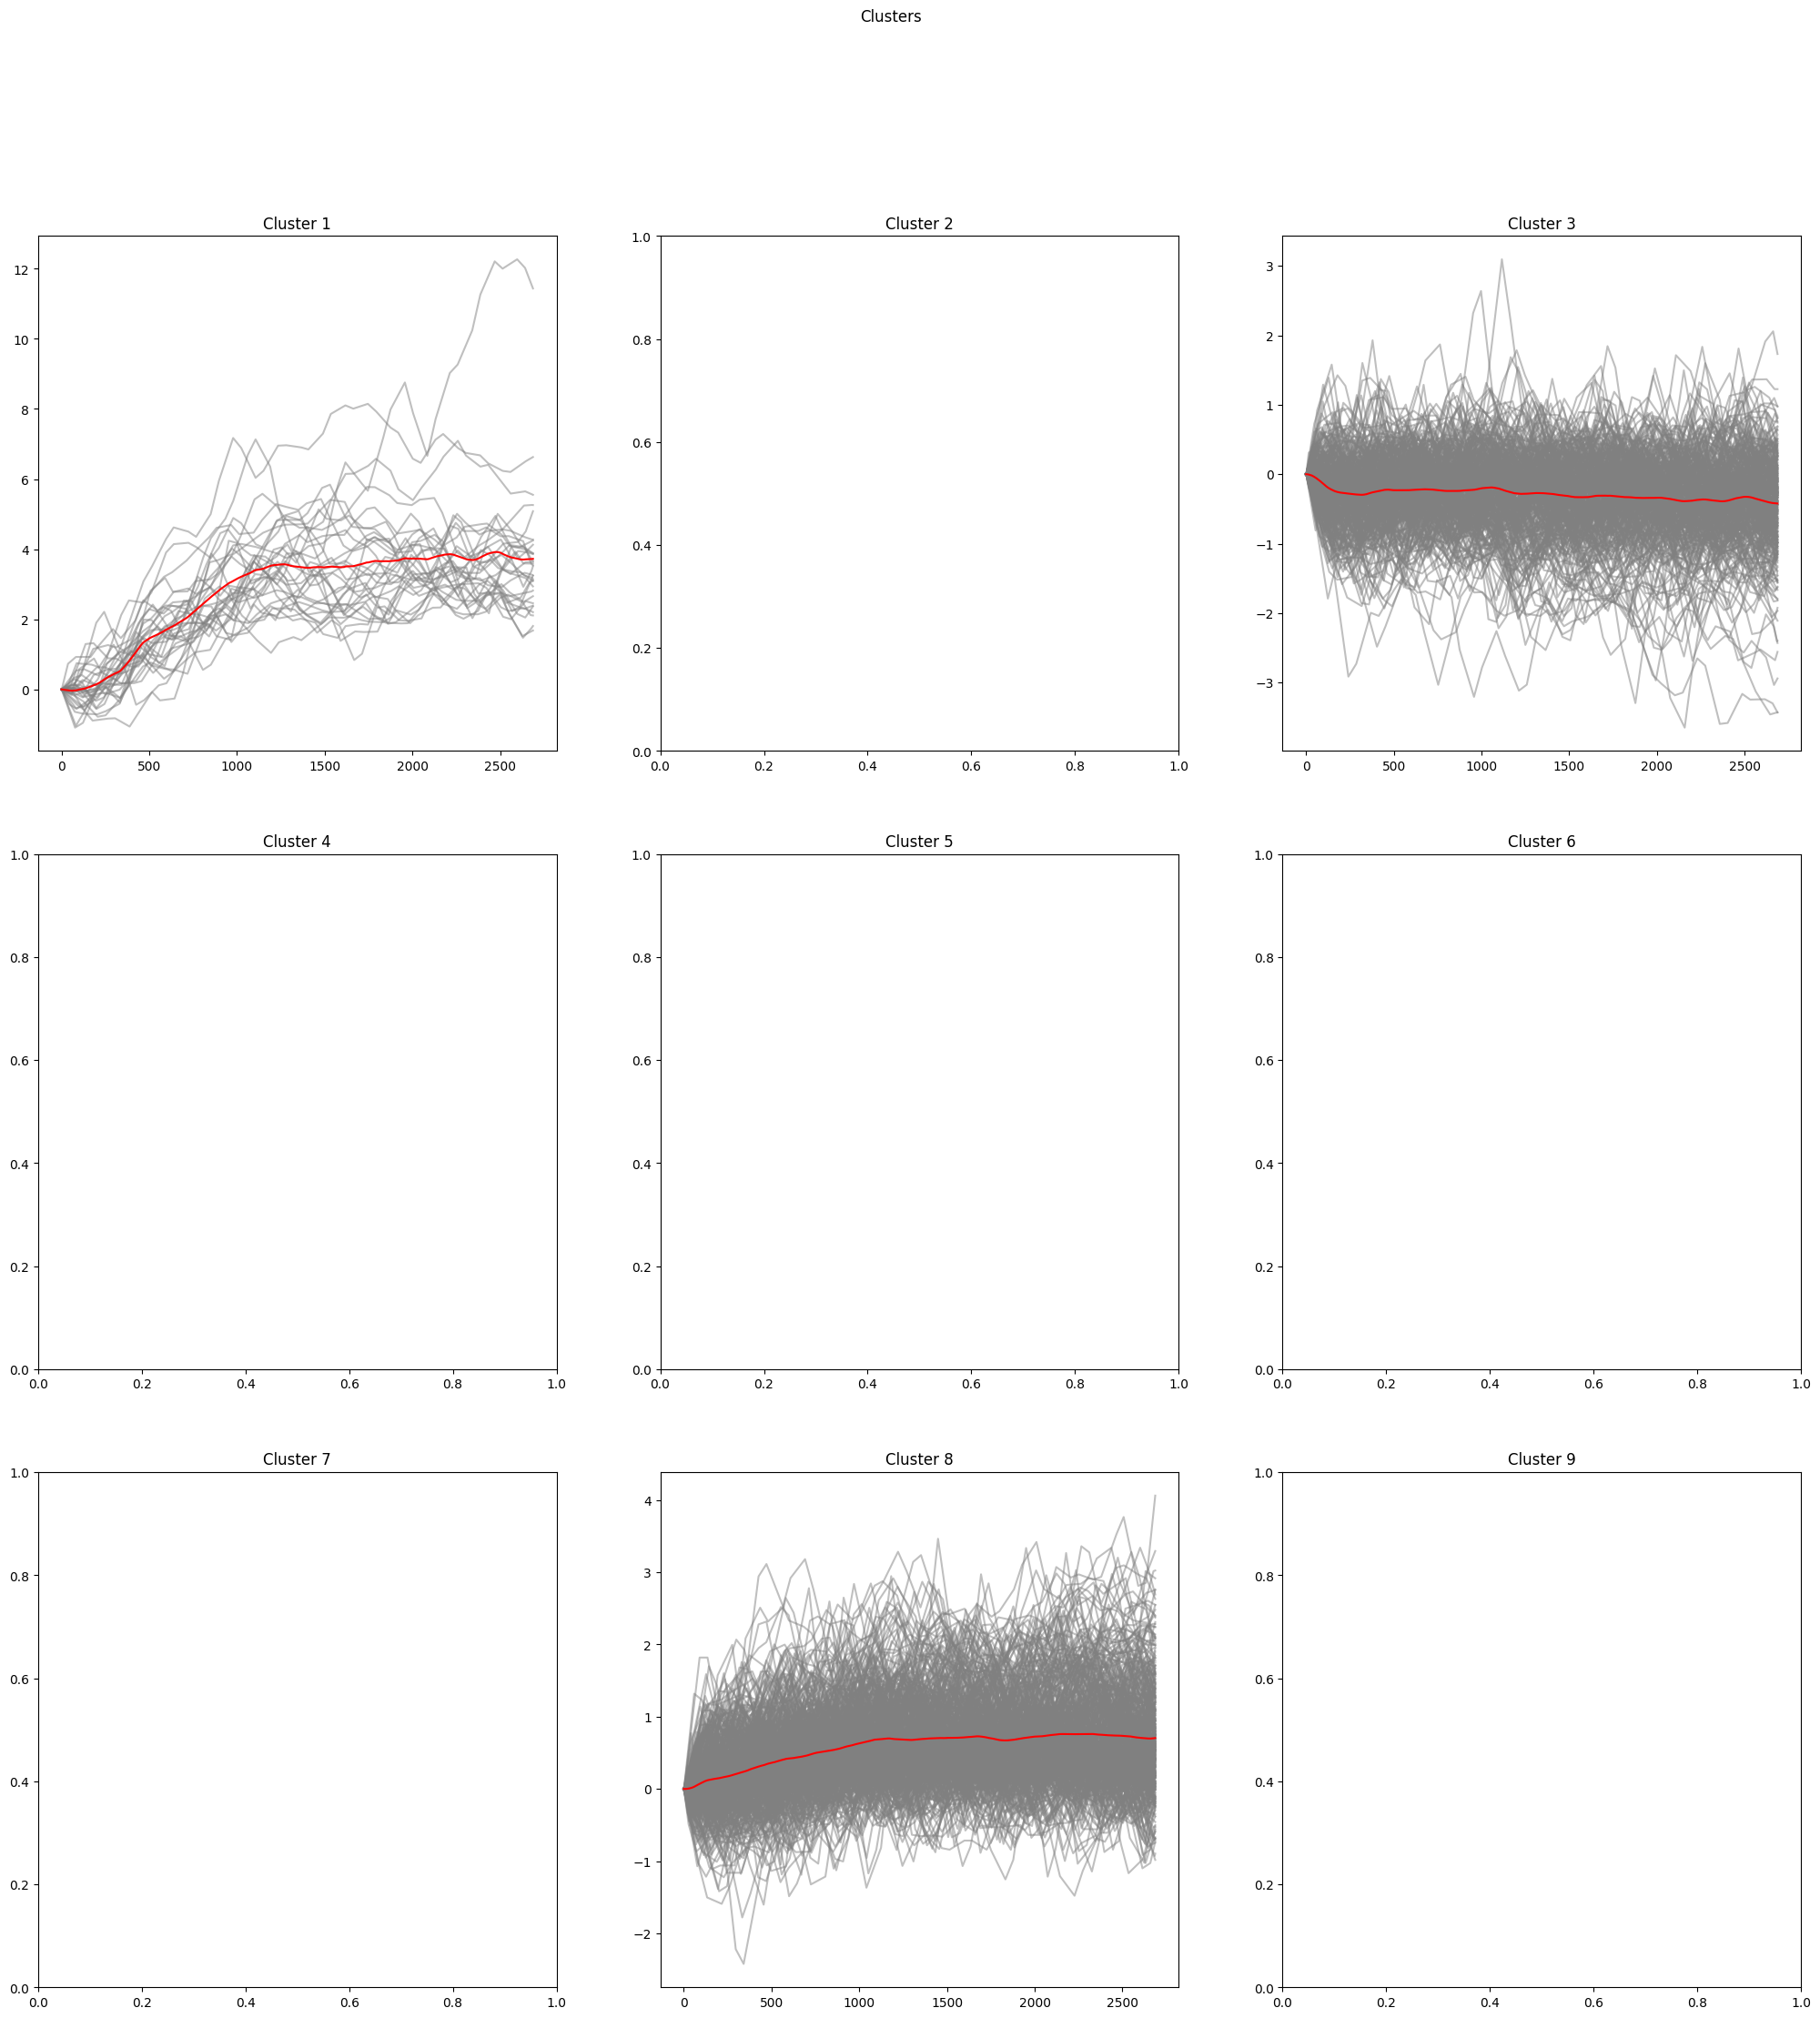

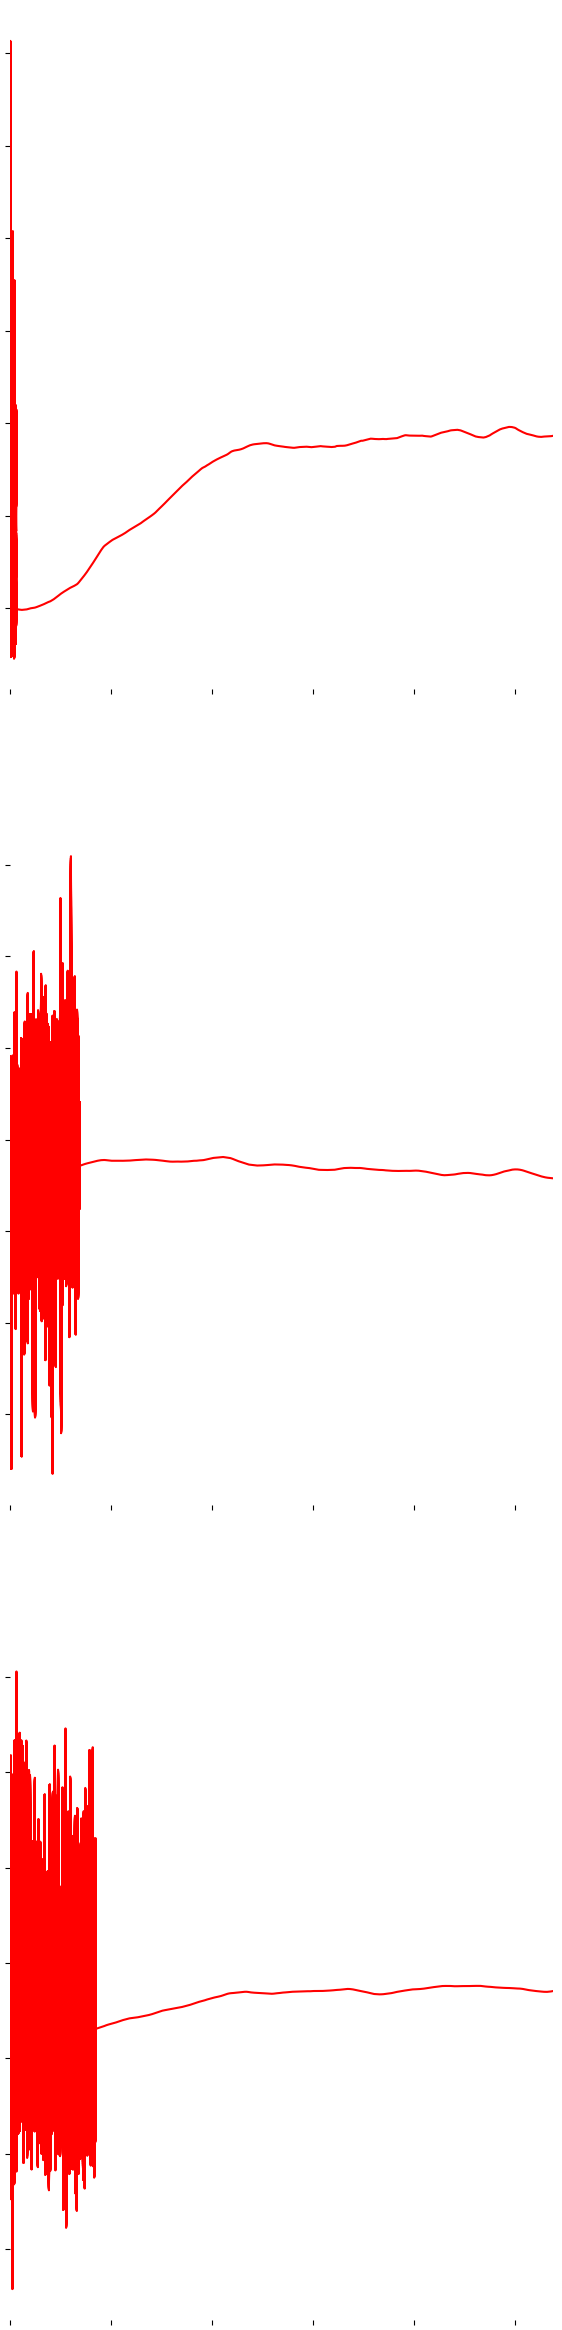

In [71]:

# # Algorithms
# from minisom import MiniSom
# import pickle

# def plot_som_series_averaged_center(som_x, som_y, win_map):
#     fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
#     fig.suptitle('Clusters')
#     for x in range(som_x):
#         for y in range(som_y):
#             cluster = (x,y)
#             if cluster in win_map.keys():
#                 for series in win_map[cluster]:
#                     axs[cluster].plot(series,c="gray",alpha=0.5) 
#                 axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
#             cluster_number = x*som_y+y+1
#             axs[cluster].set_title(f"Cluster {cluster_number}")


# def get_som_series_averaged_center(som_x, som_y, win_map):
#     clustered_traces = []
#     cluster_averages = []
#     for x in range(som_x):
#         for y in range(som_y):
#             cluster = (x,y)
#             if cluster in win_map.keys():
#                 clustered_traces.append(np.vstack(win_map[cluster]))
#                 cluster_averages.append(np.average(np.vstack(win_map[cluster]),axis=0))
#     return clustered_traces, cluster_averages

# som_x = som_y = 3 #math.ceil(math.sqrt(math.sqrt(len(traces))))
# traces = dots_OFF.transpose()
# som = MiniSom(som_x, som_y,len(traces[0]), sigma=0.5, learning_rate = 0.2, neighborhood_function='mexican_hat', random_seed=10)
# som.random_weights_init(traces)
# som.train(traces, 50000)

# #save the SOM
# with open('C:/Users/Michael Forsthofer/OneDrive - University of Sussex/BadenLab/2p-imaging/clustering analysis/mexicamhat_sigma1.5_randomseed10_lr0.1', 'wb') as outfile:
#     pickle.dump(som, outfile)

# win_map = som.win_map(traces)

# plot_som_series_averaged_center(som_x, som_y, win_map)

# clustered_traces, cluster_averages = get_som_series_averaged_center(som_x, som_y, win_map)

# f, ax = plt.subplots(len(cluster_averages), 1, figsize=(7, 30))
# for i in range(len(cluster_averages)):
#     ax[i].plot(clustered_traces[i], color='r')
#     ax[i].plot(cluster_averages[i], color='r')
#     ax[i].set_xticklabels([])
#     ax[i].set_yticklabels([])
#     ax[i].set_xlim(0, len(cluster_averages[i]))
#     ax[i].spines['top'].set_visible(False)
#     ax[i].spines['right'].set_visible(False)
#     ax[i].spines['bottom'].set_visible(False)
#     ax[i].spines['left'].set_visible(False)

# ax.tight_layout()


In [90]:
som.winner(dots_OFF[:,1])

(np.int64(2), np.int64(1))